# Part 3: Serving

In this part we will user MLRun's **serving runtime** to deploy our trained models from the previous stage a `Voting Ensemble` using **max vote** logic.  
We will also use MLRun's **Feature store** to receive the latest tag of the online **Feature Vector** we defined in the preveious stage.

By the end of this tutorial you’ll learn how to:
- Define a model class to load our models, run preprocessing and predict on the data
- Define Voting Ensemble function on top of our models
- Test the serving function locally using our `mock server`
- Deploy the function to the cluster and test it live

## Environment Setup

Since our work is done in a this project scope, we will first want to define the project itself for all our MLRun work in this notebook.

In [1]:
project_name = 'fraud-demo-v3'

In [2]:
import mlrun

# Initialize the MLRun project object
project = mlrun.get_or_create_project(project_name, context="./", user_project=True)

> 2021-09-14 00:37:54,031 [info] loaded project fraud-demo-v3 from MLRun DB


## Define Model Class
- Load models
- Predict from the FS Online service via the `source` key

In [3]:
# mlrun: start-code

In [4]:
import numpy as np
from cloudpickle import load
from mlrun.serving.v2_serving import V2ModelServer

class ClassifierModel(V2ModelServer):
    
    def load(self):
        """load and initialize the model and/or other elements"""
        model_file, extra_data = self.get_model('.pkl')
        self.model = load(open(model_file, 'rb'))
        
    def predict(self, body: dict) -> list:
        """Generate model predictions from sample"""
        print(f"Input -> {body['inputs']}")
        feats = np.asarray(body['inputs'])
        result: np.ndarray = self.model.predict(feats)
        return result.tolist()

In [5]:
# mlrun: end-code

## Define a Serving Function
- Gather ClassifierModel code from this notebook
- Define `VotingEnsemble` - Max-Vote based ensemble
- Add downloaded models to the ensemble

what does serving function means?

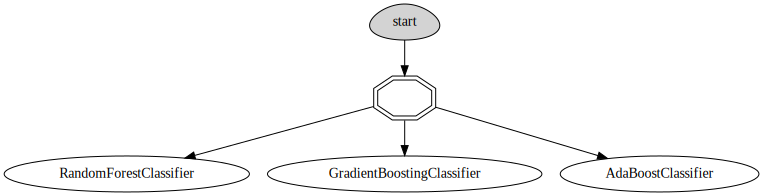

In [6]:
from mlrun import mount_v3io
import os

# Create the serving function from our code above
serving_fn = mlrun.code_to_function('transaction-fraud', kind='serving', image="mlrun/mlrun:0.7.0")

# Model-monitoring
serving_fn.metadata.project = project_name


serving_fn.set_topology('router', 'mlrun.serving.routers.EnrichmentVotingEnsemble', name='VotingEnsemble',
                feature_vector_uri="transactions-fraud-short", impute_policy={"*": "$mean"})

model_names = [
'RandomForestClassifier',
'GradientBoostingClassifier',
'AdaBoostClassifier'
]

#?
models_dir = os.path.abspath('models')

for i, name in enumerate(model_names, start=1):
    serving_fn.add_model(name, class_name="ClassifierModel", model_path=f"store://models/{project_name}/training_model#{i}:latest")

# Plot the ensemble configuration
serving_fn.spec.graph.plot()

## Test the server locally

In [7]:
# what does it mean?

In [8]:
# Create a mock server from the serving function
local_server = serving_fn.to_mock_server()

> 2021-09-14 00:38:01,625 [error] Traceback (most recent call last):
  File "/User/.pythonlibs/jupyter-alex/lib/python3.7/site-packages/mlrun/errors.py", line 57, in raise_for_status
    response.raise_for_status()
  File "/conda/lib/python3.7/site-packages/requests/models.py", line 941, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 404 Client Error: Not Found for url: http://mlrun-api:8080/api/projects/fraud-demo-v3/artifact/training_model?tag=latest&iter=1

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/User/.pythonlibs/jupyter-alex/lib/python3.7/site-packages/mlrun/datastore/datastore.py", line 133, in get_store_artifact
    url, db=self._get_db(), secrets=self._secrets, project=project
  File "/User/.pythonlibs/jupyter-alex/lib/python3.7/site-packages/mlrun/datastore/store_resources.py", line 152, in get_store_resource
    key, project=project, tag=tag or uid, 

RuntimeError: failed to load model RandomForestClassifier, artifact store://models/fraud-demo-v3/training_model#1:latest not found, 404 Client Error: Not Found for url: http://mlrun-api:8080/api/projects/fraud-demo-v3/artifact/training_model?tag=latest&iter=1: read artifact fraud-demo-v3/training_model details: {'reason': "MLRunNotFoundError('Artifact fraud-demo-v3/1-training_model#1:latest not found')"}

In [ ]:
import json

# Choose a random sample id for our test
sample_id = 'C76780537'

# Our formatted sample for server testing
formated_input = json.dumps({'inputs': [[sample_id]]})

#?
model_inference_path = '/v2/models/infer'

# Send our sample ID for predcition
local_server.test(path=model_inference_path,
            body=formated_input)

### View a sample of the online features

In [ ]:
# this is unclear, how does it relate to the local serverm is it needed

In [ ]:
import mlrun.feature_store as fs

# Create the online feature service
svc = fs.get_online_feature_service(f'{project_name}/transactions-fraud-short:latest')

# Get sample feature vector
sample_fv = svc.get([{'source': sample_id}])
sample_fv

In [ ]:
# import os
# MODEL_MONITORING_ACCESS_KEY = os.getenv('V3IO_ACCESS_KEY')

# db = mlrun.get_run_db()

# db.create_project_secrets(
#     project_name,
#     provider=mlrun.api.schemas.SecretProviderName.kubernetes,
#     secrets={"MODEL_MONITORING_ACCESS_KEY": MODEL_MONITORING_ACCESS_KEY}
# )

# # fn.set_tracking()

### Deploying the function on the kubernetes cluster

In [ ]:
# Explain here, we're not testing, we're deploying...

In [ ]:
serving_fn.deploy()

### Simulate incoming data

In [ ]:
# Load the dataset
data = mlrun.get_dataitem('https://s3.wasabisys.com/iguazio/data/fraud-demo-mlrun-fs-docs/data.csv').as_df()

# Sample 50k lines
data = data.sample(50000)

# keys
sample_ids = data['source'].to_list()

In [ ]:
from random import choice, uniform
from time import sleep

# Sending random requests
for _ in range(100):
    data_point = choice(sample_ids)
    try:
        serving_fn.invoke(path=test_path, body=json.dumps({'inputs': [data_point]}))
        sleep(uniform(0.2, 1.7))
    except OSError:
        pass